In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


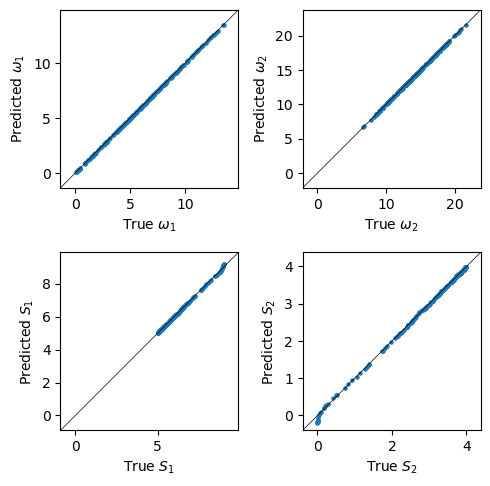

In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_39/checkpoints/epoch=3467-step=86700.ckpt")

Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val).detach())
Y_val_pred = torch.vstack(Y_val_pred)

labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [56]:
from src.utils_model import construct_fc_net, batch_spec_to_Sqt

class BayesianInference(torch.nn.Module):
    def __init__(self, model, param_prior, settings, batch_size=500, scale_factor=1.):
        """_summary_

        Parameters
        ----------
        model : torch.nn.Module
        param_prior : dict
            {'p1': {'mu': 0., 'sigma': 1.}}
        settings : tuple/list of arrays/tensors
        """
        super().__init__()
        self.register_module('model', model)
        self.param_prior = param_prior
        self.batch_size = batch_size
        self.settings = settings
        self.flattened_settings = list(itertools.product(*settings))
        self.scale_factor = scale_factor

        self.init_parameters()
        self.init_store_measurements()

    def init_parameters(self, ):
        for key in self.param_prior.keys():
            param = self.param_prior[key]['mu'] + \
                self.param_prior[key]['sigma'] * torch.randn(self.batch_size, 1)
            bounds = self.param_prior[key]['bounds']
            if bounds[0] is not None or bounds[1] is not None:
                param.clamp_(bounds[0], bounds[1])
            self.register_parameter(
                key, torch.nn.Parameter(param)
            )
    def constrain_parameters(self, ):
        with torch.no_grad():
            for key in self.param_prior.keys():
                bounds = self.param_prior[key]['bounds']
                if bounds[0] is not None or bounds[1] is not None:
                    eval(f'self.{key}').data[:] = eval(f'self.{key}').data.clamp_(bounds[0], bounds[1])

    def calculate_Sqt(self, t):
        x = torch.cat((self.J, self.D), dim=1)
        y = self.model(x)
        num_mode = y.shape[1] // 2
        omega, inten = torch.split(y, [num_mode, num_mode], dim=1)
        # batch x mode x time
        S_envelope = torch.exp(-torch.einsum("bm,t->bmt", F.relu(self.gamma), t.to(x)))
        S_pred = (batch_spec_to_Sqt(omega, inten, t.to(x)) * S_envelope).sum(dim=1)
        S_pred = self.scale_factor * S_pred / S_pred[:,0,None]
        return S_pred
    
    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        param_lst = []
        for key in self.param_prior.keys():
            param_lst.append({'params': eval(f'self.{key}')})
        optimizer = torch.optim.Adam(param_lst, lr=0.1)
        return optimizer

    def grad_desc_on_measurement(self, t, mu_S, sigma_S, maxiter=100, ret_loss_hist=False, replace_worst_with_mean=True, show_pbar=False):
        optimizer = self.configure_optimizers()
        if ret_loss_hist: loss_hist = []
        
        if show_pbar:
            pbar = tqdm(range(maxiter))
        else:
            pbar = range(maxiter)

        for i_iter in pbar:
            S_pred = self.calculate_Sqt(t)
            loss_batch = (S_pred - torch.atleast_2d(mu_S).repeat_interleave(self.batch_size,dim=0).to(S_pred)).pow(2).mean(dim=1)
            loss = loss_batch.mean()
            self.batch_loss = loss_batch.squeeze().detach().cpu()
            if loss < 0.001:
                break
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if ret_loss_hist: loss_hist.append(loss.item())
            if show_pbar: pbar.set_description(f"Iter {i_iter:4d} Loss {loss.item():4f}")

            
            if replace_worst_with_mean and ((loss_batch.max().abs() - loss_batch.min().abs())/loss_batch.min().abs() > 5.0):
                idx_loss_descending = torch.argsort(loss_batch, descending=True)
                idx_worst = idx_loss_descending[:int(self.batch_size/5)]
                idx_best =  idx_loss_descending[-int(self.batch_size/5):]
                # mask = torch.ones(batch_size, dtype=torch.bool)
                # mask[idx_worst] = False
                with torch.no_grad():
                    for key in self.param_prior.keys():
                        bounds = self.param_prior[key]['bounds']
                        if bounds[0] is not None or bounds[1] is not None:
                            eval(f'self.{key}').data[idx_worst] = \
                                eval(f'self.{key}').data[idx_best] + torch.randn_like(self.J.data[idx_worst]) * 0.01
        
        if ret_loss_hist: return loss_hist
        
    def evaluate_likelihood_over_all_settings(self, ):
        times, = self.settings
        S_pred = self.calculate_Sqt(times).detach()
        self.y_likelihood = S_pred
        mu = S_pred.mean(dim=0)
        sigma = S_pred.std(dim=0)
        return mu, sigma

    def propose_next_setting(self, ):
        mu_lklh, sigma_lklh = self.evaluate_likelihood_over_all_settings()
        id_sorted = torch.argsort(sigma_lklh, descending=True)
        for id in id_sorted:
            if id.item() in self.measured_settings_id_lst:
                continue
            else:
                break
        return id.item(), self.flattened_settings[id.item()]

    def gd_and_propose(self, t, S):
        self.grad_desc_on_measurement(t, S)
        next_id, next_setting = self.propose_next_setting()
        return next_id, next_setting

    def init_store_measurements(self, ):
        self.measured_settings_id_lst = []
        self.measured_settings_lst = []
        self.measured_mus_lst = []
        self.measured_sigmas_lst = []

    def update_store_measurements(self, setting_id, setting, mu, sigma):
        self.measured_settings_id_lst.append(setting_id)
        self.measured_settings_lst.append(setting)
        self.measured_mus_lst.append(mu)
        self.measured_sigmas_lst.append(sigma)

        self.register_buffer('measured_settings', torch.atleast_1d(torch.tensor(self.measured_settings_lst).squeeze()))
        self.register_buffer('measured_mus', torch.atleast_1d(torch.tensor(self.measured_mus_lst).squeeze()))
        self.register_buffer('measured_sigmas', torch.atleast_1d(torch.tensor(self.measured_sigmas_lst).squeeze()))


In [57]:
param_prior = {
    'J': {'mu': -1.5, 'sigma': 0.5, 'bounds': [-5, 0.]},
    'D': {'mu': -0.5, 'sigma': 0.25, 'bounds': [-2.0, 0.]},
    'gamma': {'mu': 0.5, 'sigma': 0.25, 'bounds': [0., None]},
}
times = torch.arange(0,10,0.01)

In [61]:
idx = np.random.choice(len(X_val))
x_val = X_val[idx]
y_val = Y_val[idx]

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], 0.25, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)
inten_val = inten_val / inten_val.sum() * y_val[-2:].sum()
true_pars = x_val.cpu().numpy().tolist() + [0.25,]


true_S = batch_spec_to_Sqt(omega_val, inten_val, times).sum(dim=1).squeeze().detach().cpu().numpy()
func_S = interp1d(times.cpu().numpy(), true_S)
sigma_noise = 0.1 * true_S[0]
def measure_t(t, sigma_noise=0.):
    if isinstance(t, (float,int)):
        t = np.array([t,]).astype('float64')
    elif isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    return func_S(t) + sigma_noise * np.random.randn(*t.shape)

In [62]:
settings_measurements = []
mu_measurements = []
sigma_measurements = []
S0 = np.asarray([measure_t(0) for i in range(100)]).mean()

bayes = BayesianInference(model_spec, param_prior, (times,), scale_factor=S0)


In [63]:

print(x_val)
print(y_val)
print(bayes.model(x_val))

tensor([-2.5760, -0.7125])
tensor([ 7.1198, 18.3559,  5.2199,  3.7801])
tensor([ 7.1028, 18.3771,  5.2114,  3.7799], grad_fn=<SqueezeBackward3>)


In [71]:
bayes.init_parameters()
next_id, next_setting = bayes.propose_next_setting()
next_measurement = np.asarray([measure_t(next_setting[0], sigma_noise) for i in range(10)])
mu_next_measurement, sigma_next_measurement = next_measurement.mean(), next_measurement.std()

bayes.update_store_measurements(next_id, next_setting, mu_next_measurement, sigma_next_measurement)

for i in range(100):
    loss_hist = bayes.grad_desc_on_measurement(
        bayes.measured_settings, bayes.measured_mus, bayes.measured_sigmas, maxiter=500, ret_loss_hist=True, 
        replace_worst_with_mean=True)

    next_id, next_setting = bayes.propose_next_setting()
    next_measurement = np.asarray([measure_t(next_setting[0], sigma_noise) for i in range(10)])
    mu_next_measurement, sigma_next_measurement = next_measurement.mean(), next_measurement.std()

    bayes.update_store_measurements(next_id, next_setting, mu_next_measurement, sigma_next_measurement)

    
    print(next_setting, loss_hist[-1])
    if loss_hist[-1] < 1:
        break

(tensor(2.7100),) 5.297163159093407
(tensor(2.3600),) 5.358301605928782
(tensor(2.5500),) 5.451571257651876
(tensor(1.2900),) 5.437211902712025
(tensor(1.5000),) 5.506413046027248
(tensor(2.3000),) 5.667463516090113
(tensor(2.3200),) 5.708723312837386
(tensor(3.1500),) 5.747881758174357
(tensor(2.3500),) 5.723687318522081
(tensor(1.5500),) 5.782018110872418
(tensor(1.5600),) 5.8816481820070114
(tensor(1.6300),) 5.93351689627246
(tensor(1.1900),) 5.935596184975149
(tensor(1.3200),) 5.901682844193062
(tensor(1.5200),) 5.9525040788422485
(tensor(1.6000),) 5.992362169293319
(tensor(1.2600),) 6.032881620832966
(tensor(1.7700),) 6.094360564888413
(tensor(1.2100),) 6.14843686503009
(tensor(1.1800),) 6.147130444229208
(tensor(1.5700),) 6.106439830375546
(tensor(1.7800),) 6.126099788160798
(tensor(2.0700),) 6.228860684023633
(tensor(2.3700),) 6.266448973332486
(tensor(1.5300),) 6.250156336272667
(tensor(1.1700),) 6.25452061853065
(tensor(0.7300),) 6.204062486452936
(tensor(1.9200),) 6.213182119

KeyboardInterrupt: 

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 498.]),
 array([1.45320764, 1.45320764, 1.45320764, 1.45320764, 1.45320764,
        1.45320764, 1.45320764, 1.45320764, 1.45320764, 1.45320764,
        1.45320764]),
 <BarContainer object of 10 artists>)

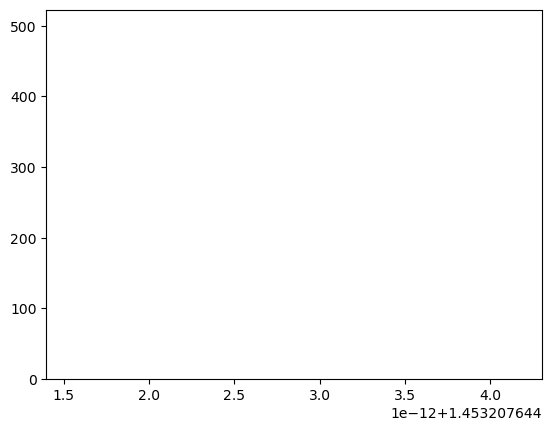

In [72]:
# bayes.init_parameters()

plt.hist(bayes.gamma.data.squeeze())

In [73]:
# bayes.J.data[:] = bayes.J.data / bayes.J.data * x_val[0]
# bayes.D.data[:] = bayes.D.data / bayes.D.data * x_val[1]
# bayes.gamma.data[:] = torch.ones_like(bayes.gamma.data) * 0.25
mu, _ = bayes.evaluate_likelihood_over_all_settings()

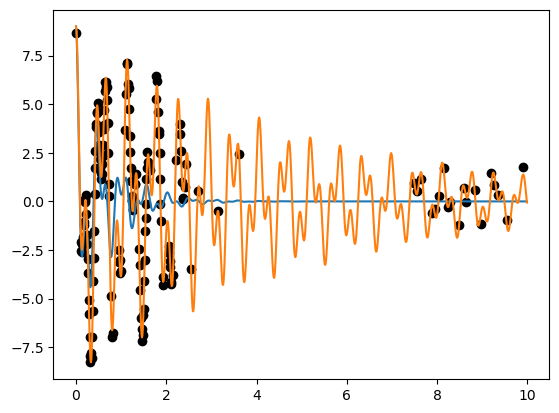

In [74]:
plt.plot(times, bayes.y_likelihood.mean(dim=0))
# plt.plot(times, mu, '-')
plt.scatter(bayes.measured_settings, bayes.measured_mus_lst, c='k')
plt.plot(times, measure_t(times))